# 14. Anwendung Deep Learning: Empfehlungssysteme für Filme

Diese Sitzung behandelt die Arbeit mit der fastai Library zur Erstellung von Emfehlungssystemen, sogenanntem kollaborativen Filtern. In dieser Sitzung besprechen wir Beispiele aus der fastai-Dokumentation. Dieses Beispiel und der zugehörige Code finden sich unter folgenden Links:

https://colab.research.google.com/github/fastai/fastai/blob/master/nbs/46_tutorial.collab.ipynb

https://github.com/fastai/fastbook/blob/master/08_collab.ipynb


## Wichtig: Jedes fastai Beispiel (und spätere Projekt) folgt den gleichen 4 Schritten:
1. Eine gleich bleibende API/Schnittstelle zur Sammlung und Analyse von Daten verwenden sowie zur Erstellung von Labeln
2. Einen "Learner" erstellen: dieser kombiniert Daten und Modelle für das Training und benutzt bereits vorgefertigte Modelle um die Trainingsdauer zu reduzieren
3. Das Training des Modells
4. Die Überprüfung einiger Vorhersagen des Modells

## 1. Import und Update der Library

fastai ist eine externe Library aus der Sicht von Google Colab. Diese muss vor Start der Arbeit manuell installiert und aktualisiert werden. Import und Update führen wir mit folgendem Codezeilen durch:

In [ ]:
%pip install --upgrade gradio

In [1]:
! [ -e /content ] && pip install -Uqq fastai

In [2]:
!pip install -Uqq fastbook

In [3]:
import fastbook

In [4]:
import fastai

An dieser Stelle importieren wir jetzt die fastai Module für die Arbeit mit Tabellen und für kollaboratives Filtern:

In [5]:
from fastai.tabular.all import *

In [6]:
from fastai.collab import *

In [7]:
from ipywidgets import HBox,VBox,widgets,Button,Checkbox,Dropdown,Layout,Box,Output,Label,FileUpload

## 2. Erstellen eines Empfehlungssystems zur Vorhersage der Bewertung von Filmen durch Benutzer

Warum macht es Sinn, die Werte für jeden Benutzer einzeln vorherzusagen?
Nun, da jeder Mensch einen anderen Filmgeschmack hat, muss man die Empfehlungen, in diesem Fall die Bewertung eines Films durch den Benutzer, für jeden Benutzer einzeln vorhersagen. Eine allgemeine Vorhersage der Bewertung eines Films wäre weniger hilfreich.

## 2.1 Import und Bearbeitung von Daten

### 2.1.1. Laden und sammeln des Movielens 100k Datensatzes

Der Datensatz kann, wie weitere, auf der folgenden Seite heruntergeladen werden: https://grouplens.org/datasets/movielens/100k/

Wir speichern den Datensatz wie immer in einer ständigen Variable. Der Datensatz ist als ein Beispielsdatensatz in  fastai angelegt. Die folgende Funktion läd für uns automatisch den Datensatz herunter und entpackt ihn:

In [8]:
path = untar_data(URLs.ML_100k)

Im nächsten Schritt können wir uns den Speicherort der Datei in unserem Cloud-Umfeld ansehen:

In [9]:
path.ls()

(#23) [Path('/home/studio-lab-user/.fastai/data/ml-100k/allbut.pl'),Path('/home/studio-lab-user/.fastai/data/ml-100k/mku.sh'),Path('/home/studio-lab-user/.fastai/data/ml-100k/README'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u.data'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u.genre'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u.info'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u.item'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u.occupation'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u.user'),Path('/home/studio-lab-user/.fastai/data/ml-100k/u1.base')...]

Hierbei handelt es sich um eine virtuelle, temporäre Pfadumgebung, die nach dem Beenden des Notebooks ebenfalls gelöscht wird.

Da es sich hierbei um tabellarische Daten handelt müssen die Daten so formatiert werden, dass man in einem Framework brauchbar damit arbeiten kann.
In einem ersten Schritt speichern wir die Benutzer, den Film und die dazugehörigen Bewertungen der Benutzer in der Variable "Ratings".
 Dies tun wir in unserem altbekannten Pandas-Dataframe:

In [10]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, usecols=(0,1,2), names=['user','movie','rating'])

Es handelt sich bei der ursprünglichen Datei um eine "anders" formatierte Tabelle. Wir mussten Pandas einige zusätzliche Vorgaben machen, damit wir mit den Daten arbeiten können. Dies muss euch aber im Detail nicht interessieren. Falls ihr es nachgucken wollt schaut gerne in den originalen Datensatz und die Pandas Dokumentation: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

Wir können uns jetzt ein Beispiel aus Ratings mit der altbekannten .head() Funktion anzeigen lassen:

In [11]:
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [12]:
ratings.tail()

,user,movie,rating
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2
99999,12,203,3


Wie euch sicherlich aufgefallen ist haben wir jetzt die Nutzer, Filme und die dazugehörigen Ratings extrahiert. Das Problem, welches wir jetzt haben, ist allerdings, dass uns die Namen der Filme fehlen. Jeder Film in diesem Datensatz hat eine Zahl. Im nächsten Schritt müssen wir die Filme als ein zusätzliches Pandas-Dataframe extrahieren und in einer Variable "movies" speichern:

In [13]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie','title'), header=None)

Nun haben wir die Filme mit ihrer Kennung und dem dazugehörigen Titel in der Variable "movies" gespeichert. Schauen wir uns diese mit der .head() Funktion an:

In [14]:
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [15]:
movies.tail()

,movie,title
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)
1681,1682,Scream of Stone (Schrei aus Stein) (1991)


In diesem Dataframe sehen wir jetzt die Kennung/ID der Filme und den dazugehörigen Titel.

In einem letzten Schritt müssen wir jetzt beide Tabellen zusammenführen. Dies tun wir, in dem wir die .merge() Funktion von Pandas verwenden:

In [16]:
ratings_combined = ratings.merge(movies)
ratings_combined.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


Zum vereinfachten Verständnis könnte man das finale Ergebnis nach der Zusammenführung der Daten auch in einer Kreuztabelle darstellen:

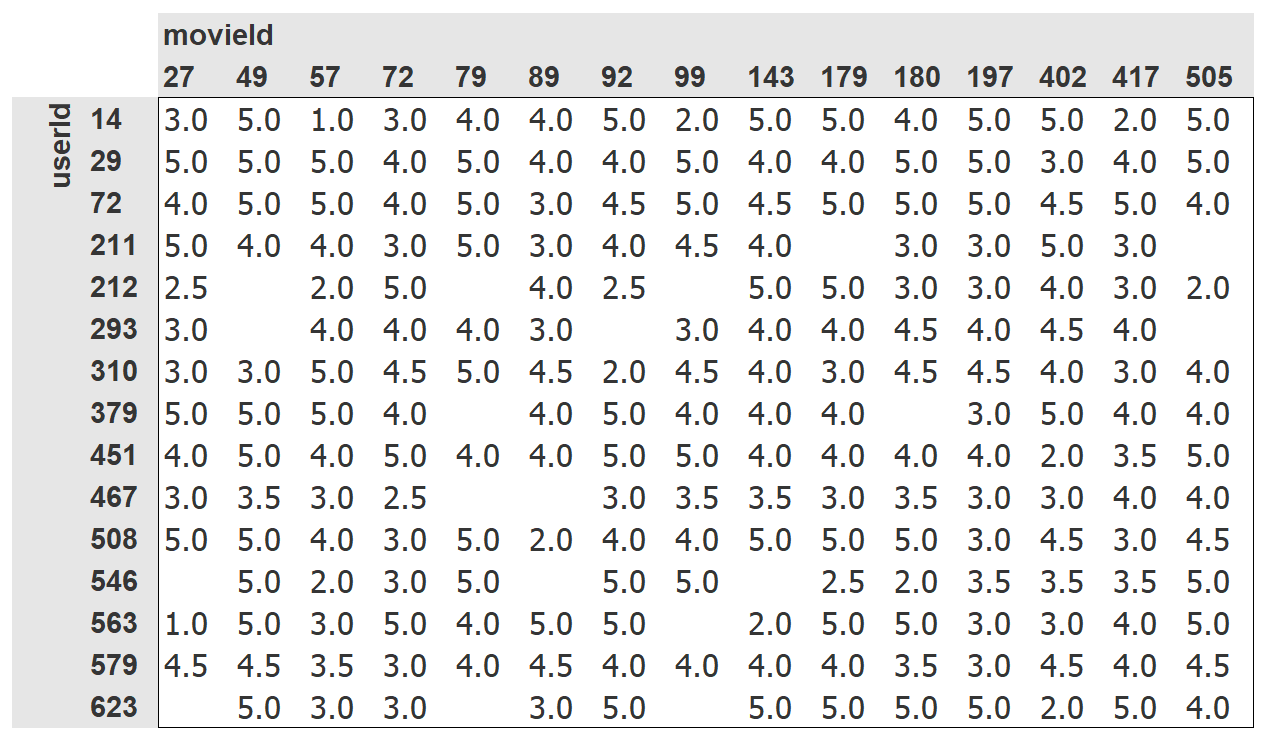

Und hier eine Darstellung des Original-Datensatzes mittels Pandas:

In [17]:
ct = pd.pivot(ratings_combined, index='user', columns='movie')

In [18]:
ct

rating                                                                   \
movie   1    2    3    4    5    6    7    8    9    10   11   12   13   14     
user                                                                            
1        5.0  3.0  4.0  3.0  3.0  5.0  4.0  1.0  5.0  3.0  2.0  5.0  5.0  5.0   
2        4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  4.0  4.0   
3        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN   
5        4.0  3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
939      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  NaN   
940      NaN  NaN  NaN  2.0  NaN  NaN  4.0  5.0  3.0  NaN  NaN  4.0  NaN  3.0   
941      5.0  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
942      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
943      NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  5.0  NaN  NaN   

                                                                             \
movie 15   16   17   18   19   20   21   22   23   24   25   26   27   28     
user                                                                          
1      5.0  5.0  3.0  4.0  5.0  4.0  1.0  4.0  4.0  3.0  4.0  3.0  2.0  4.0   
2      NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5      NaN  NaN  4.0  NaN  NaN  NaN  3.0  NaN  NaN  4.0  3.0  NaN  NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
939    5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
940    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
941    4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
942    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
943    NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  4.0  4.0  NaN  NaN  4.0  4.0   

                                                                             \
movie 29   30   31   32   33   34   35   36   37   38   39   40   41   42     
user                                                                          
1      1.0  3.0  3.0  5.0  4.0  2.0  1.0  2.0  2.0  3.0  4.0  3.0  2.0  5.0   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5      4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  5.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
939    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
940    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
941    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
942    NaN  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
943    NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  4.0  5.0   

                                                                             \
movie 43   44   45   46   47   48   49   50   51   52   53   54   55   56     
user                                                                          
1      4.0  5.0  5.0  4.0  4.0  5.0  3.0  5.0  4.0  4.0  3.0  3.0  5.0  4.0   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN   
5      NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN   
...    ...  ...  ...  ...

###2.1.2. Erstellung eines fastai DataLoaders für tabellarische Daten

Zur Verwendung von Daten für Modelle in der fastai Library müssen diese zusätzlich mittels eines sogenannten **DataLoaders** verarbeitet werden. In unserem Fall nutzen wir den vorher zusammengeführten ("merged") Datensatz. Als Bezeichnung ("item_name") verwenden wir in diesem Fall den Filmtitel:

In [19]:
dls = CollabDataLoaders.from_df(ratings_combined, item_name='title', bs=64)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Wie in der vorherigen Sitzung auch können wir uns nun einen Ausschnitt der Ergebnisse in Form von batches anzeigen lassen:

In [20]:
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


### 2.2 Erstellung eines fastai-Learners

Mit Hilfe des fastai-Learner laden wir jetzt unsere Daten (dls) und geben die Reichweite der abhängigen Variable, y, vor. In unserem Fall handelt es sich hierbei um die Filmbewertung:

In [21]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

(n_factors gibt die Höhe der latenten Faktoren an.  Ziel des Parameter ist es, unbekannte Muster in Daten zu erfassen. Es gibt keinen vordefinierten, optimalen Wert für diesen Parameter, an dieser Stelle erfasst er aber die Beziehung zwischen Nutzerbewertungen und Vorhersagen der Bewertung in unseren Daten. Hierzu findet ihr mehr in Kapitel 8 des fastai-Buchs oder unter:

https://medium.com/geekculture/fastai-chapter-8-questions-answers-52d3583d626b)

###2.3 Training eines Modells für kollaboratives Filtern

Zum Training des Modells passen wir die Daten aus unserem Learner-Objekt jetzt mittels der 1cycle policy an. Hier geben wir unter anderem die Anzahl der Durchgänge (Epochen) und die Lernrate an.
Mehr Informationen dazu findet ihr unter:

https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle  

In [22]:
learn.fit_one_cycle(2, 5e-3, wd=0.1)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,time
0,0.914163,0.909590,00:15
1,0.787871,0.853611,00:15


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is de

Zum finden der optimalen Lernrate kann man auch die lr_find Funktion (**"Learnrate-Find-Funktion"**) verwenden:

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is de

SuggestedLRs(valley=0.0008317637839354575)

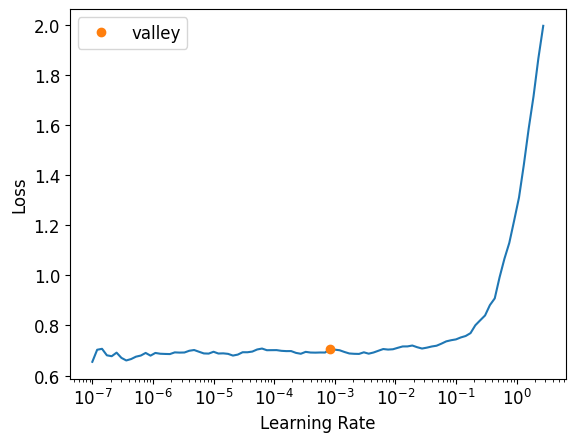

In [23]:
learn.lr_find()

### 2.4 Überprüfung / Validierung des trainierten Modells

Abschließend können wir uns die Ergebnisse des Traingsprozesses für unseren kollaborativen Filter mit der .show_results() Funktion anzeigen lassen.

Hier sehen wir, wie nah unser Modell mit der Vorhersage an den tatsächlichen Bewertungen der Benutzer war:



(Mehr zur .show_results() Funktion findet ihr hier:
https://docs.fast.ai/learner.html#Learner.show_results)

In [24]:
learn.show_results(max_n=30)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


,user,title,rating,rating_pred
0,648,436,3,3.225451
1,224,1227,3,2.984573
2,126,795,5,2.775563
3,896,1461,5,3.803044
4,807,114,4,4.280611
5,186,334,1,4.081571
6,874,477,4,2.854900
7,65,374,5,3.991852
8,200,1174,4,4.280627
9,94,3,3,2.643358


Zur Extraktion einzelner Vorhersagen verwandeln wir die Vorhersagen der Learn-Function in ein Dataframe und rufen diese mittels einer Funktion ab:

In [25]:
preds, y = learn.get_preds()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is de

In [26]:
preds = preds.numpy().flatten()  # Flatten the predictions

In [27]:
# Create a DataFrame with predictions
pred_df = pd.DataFrame({'rating_pred': preds})

In [28]:
# Add the user and movie information
pred_df['user'] = ratings_combined['user']
pred_df['title'] = ratings_combined['movie']

In [ ]:
# Optionally, add actual ratings if needed
# pred_df['rating'] = y.numpy()

In [29]:
# Export to CSV
pred_df.to_csv('predictions.csv', index=False)

In [30]:
pred_df

,rating_pred,user,title
0,4.440500,196,242
1,3.623077,63,242
2,3.884941,226,242
3,3.692537,154,242
4,3.995964,306,242
...,...,...,...
19995,2.946075,929,135
19996,3.028069,645,135
19997,2.819979,495,135
19998,3.573174,847,135


Ausgabe der Menge an Vorhersagen, die gespeichert wurden:

In [31]:
preds, targets = learn.get_preds()
num_predictions = len(preds)
print("Number of predictions:", num_predictions)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is de

Number of predictions: 20000


Durch Eingabe des Nutzers und der Kennung/ID des Filmtitels können über die folgende Funktion die Vorhersagen abgerufen werden:

In [32]:
user = 929
title = 135

In [33]:
row = pred_df[(pred_df['user'] == user) & (pred_df['title'] == title)]
if row.empty:
    print("No prediction found for user", user, "and movie", title)
else:
    prediction = row['rating_pred'].values[0]
    print("Prediction for user", user, "and movie", title, ":", prediction)

Prediction for user 929 and movie 135 : 2.9460754


In [34]:
import gradio as gr
import pandas as pd

In [35]:
# Assuming 'pred_df' is your DataFrame with predictions
# Ensure 'pred_df' is loaded or accessible in this script

# Load your ratings_combined DataFrame
# Ensure 'ratings_combined' is loaded or accessible in this script

# Create lists of unique users and movies with titles
unique_users = ratings_combined['user'].unique().tolist()
unique_movies = ratings_combined[['movie', 'title']].drop_duplicates()
movie_options = ["{} - {}".format(row['movie'], row['title']) for _, row in unique_movies.iterrows()]

In [40]:
def predict_rating(user, movie_with_title):
    # Extract movie ID from the selection
    movie_id = int(movie_with_title.split(" - ")[0])
    
    row = pred_df[(pred_df['user'] == user) & (pred_df['title'] == movie_id)]
    if row.empty:
        return "No prediction found for user {} and movie {}".format(user, movie_id)
    else:
        prediction = row['rating_pred'].values[0]
        return "Vorhergesagte Bewertung für den Benutzer {} und den Film {}: {:.2f}".format(user, movie_id, prediction)

In [41]:
# Create Gradio dropdowns for user and movie
user_input = gr.Dropdown(label="User ID", choices=unique_users)
movie_input = gr.Dropdown(label="Movie", choices=movie_options)

In [42]:
# Create the interface
iface = gr.Interface(
    fn=predict_rating,
    inputs=[user_input, movie_input],
    outputs="text",
    title="Movie Rating Prediction",
    description="Select a User ID and a Movie to predict the movie rating"
)

Sie haben in ihrem SageMaker-Account eine einzigartige Lab Domain. Diese sehen Sie in ihrem Browser. Fügen Sie diese unten in der Variable "lab_domain" ein:

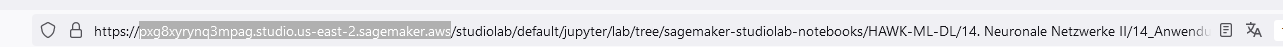

In [43]:
# Launch the Gradio app
gr.close_all()
port = 8080
root_path = f"/studiolab/default/jupyter/proxy/{port}"
iface.launch(server_port=8080, root_path=root_path, inline=False)
lab_domain = "pxg8xyrynq3mpag.studio.us-east-2.sagemaker.aws"
print(f"Please access https://{lab_domain}/studiolab/default/jupyter/proxy/{port}/")

Closing server running on port: 8080
Running on local URL:  http://127.0.0.1:8080

To create a public link, set `share=True` in `launch()`.
Please access https://pxg8xyrynq3mpag.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/proxy/8080/


Weitere Ansätze zur Vorhersage im Rahmen von fastai Collab findet ihr zum Beispiel hier:

https://medium.com/@igorirailean/a-recommender-system-using-fastai-in-google-colab-110d363d422f

https://forums.fast.ai/t/cant-predict-on-tabular-or-collab-learners/80095/5

https://forums.fast.ai/t/collablearner-prediction/34868/2